Below is the code for calculationg ENPV with a modified method, using uniform distribution to select the initial injection rates and seed to keep the BO gusses same to be able to compare the caculation time between base case and modified method. all injection rates are considered to be the same.

In [1]:
# import necessary packages

from ecl.summary import EclSum
import sys
import os
import numpy as np
from array import *
import pandas as pd
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import matplotlib.pyplot as plt
from numpy.random import seed
seed(12345)


In [2]:
# parameters that we need to calculate ENPV

OP =  300   #Oil Price $ per m3
WPP = 47.5    #Water Production Price $ per m3
WIP = 12.5  #WaterInjection Price $ per m3
Study_period = np.arange(10) #Years
DiscountRate = 0.08
NPV = []
Inj_rate_Opt = []
NPV_Opt = []


In [3]:
# Modify Injection Rates

def modify_InjRate(Init_InjRate):

    Schedule_NEW_sample=pd.read_csv('SCHEDULE_NEW_sample.INC')

    for i in np.arange(0,8):
        #print("InjRate=" , Init_InjRate)
        Schedule_NEW_sample['WCONINJE'][0] = Schedule_NEW_sample['WCONINJE'][0].replace('U1' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][1] = Schedule_NEW_sample['WCONINJE'][1].replace('U2' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][2] = Schedule_NEW_sample['WCONINJE'][2].replace('U3' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][3] = Schedule_NEW_sample['WCONINJE'][3].replace('U4' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][4] = Schedule_NEW_sample['WCONINJE'][4].replace('U5' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][5] = Schedule_NEW_sample['WCONINJE'][5].replace('U6' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][6] = Schedule_NEW_sample['WCONINJE'][6].replace('U7' , str(Init_InjRate))
        Schedule_NEW_sample['WCONINJE'][7] = Schedule_NEW_sample['WCONINJE'][7].replace('U8' , str(Init_InjRate))

    Schedule_NEW_sample.to_csv('SCHEDULE_NEW.INC',index=False)




In [4]:
# NPV calculation function

def NPV_Calc():
    ''' In this function, we need to read the data provided by Eclips simulator,
    then, Eclips provides data for 10 years with intervals of 30 days, I considered every 360 days as a year, 
    since the discount rate is provided as yearly basis, I chose yearly data, calculated net cash flows for evey year,
    discounted yearly and summed up all the discounted cash flows to calculate the NPV,
    This is done for every realizations'''
    
    summary = EclSum("ENSEMBLE_1.UNSMRY")
    Time = summary.numpy_vector("TIME")
    Years = summary.numpy_vector("YEARS")
    FOE = summary.numpy_vector("FOE")
    FOPR = summary.numpy_vector("FOPR")
    FOPT = summary.numpy_vector("FOPT")
    FPR = summary.numpy_vector("FPR")
    FWCT = summary.numpy_vector("FWCT")
    FWIR = summary.numpy_vector("FWIR")
    FWPR = summary.numpy_vector("FWPR")
    FWPT = summary.numpy_vector("FWPT")

    df = pd.DataFrame(list(zip(Time, Years, FOE, FOPR, FOPT,FPR, FWCT, FWIR, FWPR, FWPT)), 
    columns=["Time", "Years", "FOE","FOPR", "FOPT","FPR","FWCT", "FWIR","FWPR","FWPT"])
    df2=df[['Time','FOPT','FWPT', 'FWIR']]
    df2=df2.iloc[11::12]
    df2.reset_index(drop=True, inplace=True)
    NetCashFlows = OP * np.array(df2['FOPT']) - WPP * np.array(df2['FWPT']) - WIP * (np.array(df2['FWIR'])*360)
    DiscountFactors_end = 1/(1+DiscountRate)**Study_period
    DiscountedNetCashFlows = NetCashFlows*DiscountFactors_end
    NPV_end = sum(DiscountedNetCashFlows)/6.29
    NPV.append(NPV_end)
    #print("NPV_end for realization: " ,  NPV_end)
    return NPV


In [5]:
# NPV function which will be passes to BO

def NPV_BO(X_init):
    '''In this function, we will calculate the ENPV, first we need to open each realization's directory, 
    change the injection rates according to what BO suggests, run the simulator, then calculate the NPV for the 
    1st realization, if the NPV calculated in the 1st realization is greater than the average ENPV calculated
    from initial injection rates, other 9 realizations with be run and their NPVs will be calculated, otherwise,
    BO will provide another injection rate'''
    for i in X_init:
        for k in i:
            for u in range(1,11):
                os.chdir('/home/mina/Documents/Data/ENPV-Calc/' + str(u))
                modify_InjRate(k)
                os.system(command='flow Ensemble_1.DATA > /dev/null')
                NPV_Calc()
                if u ==1 and NPV < ENPV_max:
                    break
            #print('NPV: ' , NPV)
            ENPV=round(sum(NPV)/len(NPV),4)
            print('ENPV of ' + str(k) , ': ', ENPV)
        NPV.clear()
        #print("NPV_now: " , NPV)
    return ENPV

In [6]:
# 10 initial values selected with uniform distribution
X_init = np.array([[76.0329],[96.3241],[5.7969],[15.1122],[33.3769],[67.3591],[81.9322],[87.8567],[96.6415],[73.7501]])
Y_init = np.array([[1.04339392e+08],
                   [9.69726948e+07],
                   [2.78021960e+07],
                   [6.64303849e+07],
                   [9.96255671e+07],
                   [1.06391346e+08],
                   [1.02514223e+08],
                   [1.00394251e+08],
                   [9.68430430e+07],
                   [1.04960784e+08],])


In [7]:
# I used Bayesian optimization package here I initialize the BO

#X_init = np.around(np.random.uniform(low=5, high=100, size=(10)), 4).reshape(10,1)
ENPV_max=np.max(Y_init)
bounds = np.array([[5, 100]])
k = GPy.kern.RBF(1)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=NPV_BO, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=k,
                                 acquisition_type ='EI',
                                 X=X_init,
                                 Y = -Y_init,
                                 maximize=True)



In [8]:
# I run the BO for 10 iterations

optimizer.run_optimization(max_iter=10)

ENPV of 57.55270173036845 :  107483486.7496
ENPV of 77.90350705373396 :  105710578.8942
ENPV of 59.759011446595125 :  107379034.3401
ENPV of 59.535516841385146 :  107393012.5878
ENPV of 59.41871135952031 :  107401072.1495
ENPV of 59.315618863736724 :  107407165.3897
ENPV of 42.88839434097978 :  105264167.4191
ENPV of 25.972934200058024 :  93019668.6723
ENPV of 48.195449147980185 :  106759922.4245
ENPV of 38.30370466158602 :  105179153.8253


In [9]:
optimizer.fx_opt

-107483486.7496

In [10]:
optimizer.x_opt

array([57.55270173])

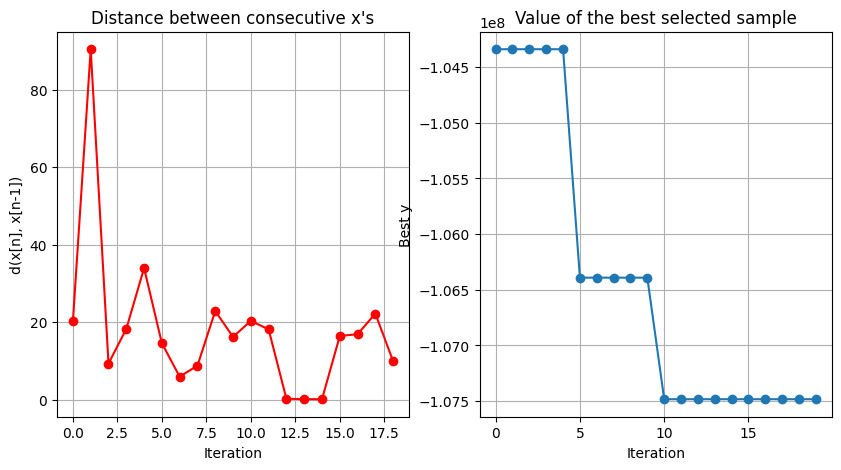

In [12]:
optimizer.plot_convergence()

In [13]:
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

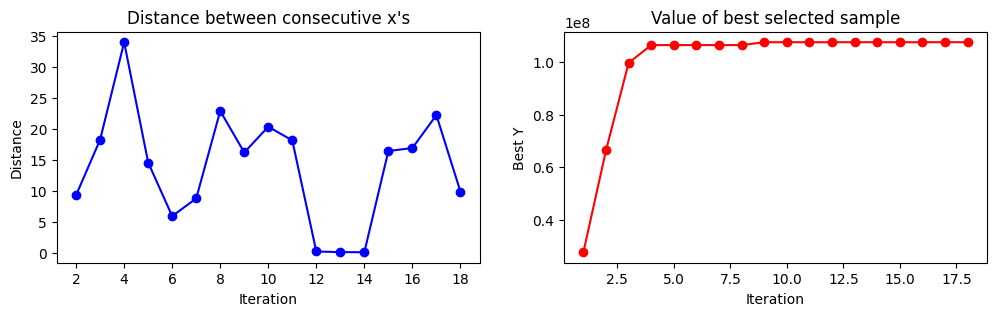

In [14]:
plot_convergence(optimizer.X,-optimizer.Y)


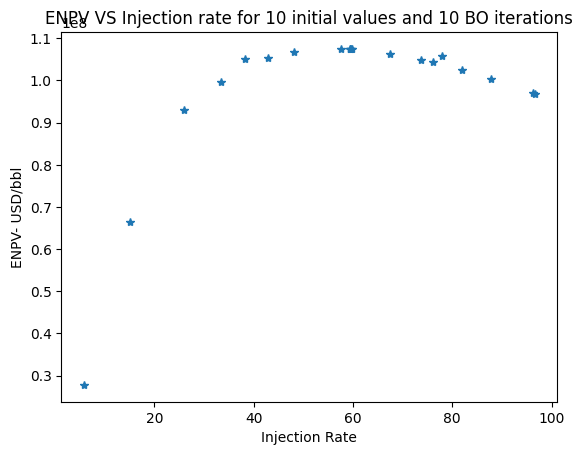

In [16]:
x= optimizer.X
y=-optimizer.Y
x=x.flatten()
y=y.flatten()
plt.plot(x,y,'*')
plt.xlabel("Injection Rate")
plt.ylabel("ENPV- USD/bbl")
plt.title("ENPV VS Injection rate for 10 initial values and 10 BO iterations")
plt.show()